# IRT Solver - Unidimensional Latent Variable Data Generation
We first assume that each item measures a single sub-scale, and we report population scores on the same sub-scale. Thus, the problem can be solved separately for every sub-scale.

To test our non-parametric IRT model, we generate items with a parameteric form and sample student abilities from the standard prior distributions assumed in IRT literature. We then use our solver (simulated annealing and IRF refinement out loop, with MCMC estimation of $\theta$ within each step).

In [58]:
# Simulate MCMC model data: pick the true parameter variables from the model's prior distribution.
#import cluster.cntree.cntree as cntree
import collections
import logging
import matplotlib.pyplot as plt
import nirt.irf
import nirt.likelihood
import nirt.mcmc
import nirt.simulate.simulate_data
import nirt.simulate.plot_irf
import nirt.solver
import numpy as np
import numpy.matlib
from numpy.linalg import norm, svd

%load_ext autoreload
%autoreload 2

level = logging.INFO
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(level=level, format="%(levelname)-8s %(message)s", datefmt="%a, %d %b %Y %H:%M:%S")

# Deterministic results.
numpy.random.seed(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
# Number of persons.
P = 1000
# Number of items.
I = 20
# Number of latent ability dimensions (sub-scales).
C = 1
# Fixed item asymptote (pi) as theta -> -\infty = probability of guessing.
asym = 0 # 0.25
# Constant a for all items.
discrimination = 1

In [60]:
X, theta, b, c = nirt.simulate.simulate_data.generate_dichotomous_responses(P, I, C, asymptote=asym, discrimination=discrimination)

(1000, 1)


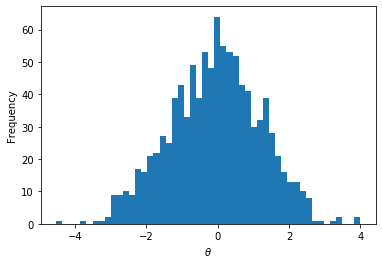

In [61]:
# Verify that student latent abilities are normally distributed. theta_c ~ N(0, invgamma(a_c,b_c))
print(theta.shape)
plt.hist(theta[:, 0], 50)
plt.xlabel(r'$\theta$')
plt.ylabel('Frequency')
plt.show()

In [62]:
print(b)
print(c)
print(np.sum(X, axis=0))

[-3.         -2.68421053 -2.36842105 -2.05263158 -1.73684211 -1.42105263
 -1.10526316 -0.78947368 -0.47368421 -0.15789474  0.15789474  0.47368421
  0.78947368  1.10526316  1.42105263  1.73684211  2.05263158  2.36842105
  2.68421053  3.        ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[913 890 843 835 766 738 696 637 569 506 481 388 333 284 235 191 149 120
 103  76]


# Initial Guess for $\theta$
Initial guess for $\theta_p^c$: the number of standard deviations person's c's success fraction is away from the mean success fraction of persons in items measuring sub-scale $c$.

When we add more persons to the simulation at each refinement step, we use the MLE ($T=0$) as the initial guess for the added persons's $\theta_p$'s.

# Building IRFs from $\theta$
The IRF of item $i$ is a 1D function of $\theta$ in this case. Use a histogram of the currently "active" persons (those being estimated) to build the IRF.

In [63]:
solver = nirt.solver.Solver(X, c, num_iterations=5, num_sweeps=5)
theta = nirt.likelihood.initial_guess(X, c)

In [64]:
# For each dimension, bin ALL persons by theta values into n bins. Binning strategy is either
# quantiles (so all bins have equal sizes) or uniform grid on a fixed domain [-M,M].
num_bins = 5
method = "uniform-fixed" # "quantile" # "uniform"
grid = [nirt.grid.Grid(theta[:, ci], num_bins, method=method, 
                       xlim=(min(theta[:, ci])-1, max(theta[:, ci])+1)) for ci in range(C)]
irf = [nirt.irf.ItemResponseFunction(grid[ci], X[:, i]) for i, ci in enumerate(c)]
# print(grid[0])

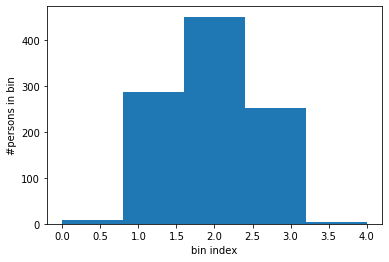

In [65]:
# Print the distribution of bin sizes.
t = theta[:, 0]
plt.hist(grid[0].bin_index, num_bins)
plt.xlabel('bin index')
plt.ylabel('#persons in bin');

In [66]:
# Generate histogram IRFs from a sample of persons.
sample_size = 20 * num_bins
inactive = np.arange(P, dtype=int)
sample = np.random.choice(inactive, size=sample_size, replace=False)
t = theta[sample]
sampled_grid = [nirt.grid.Grid(t[:, ci], num_bins, method=method, 
                       xlim=(min(theta[:, ci])-1, max(theta[:, ci])+1)) for ci in range(C)]
sampled_irf = [nirt.irf.ItemResponseFunction(sampled_grid[ci], X[sample, i]) for i, ci in enumerate(c)]

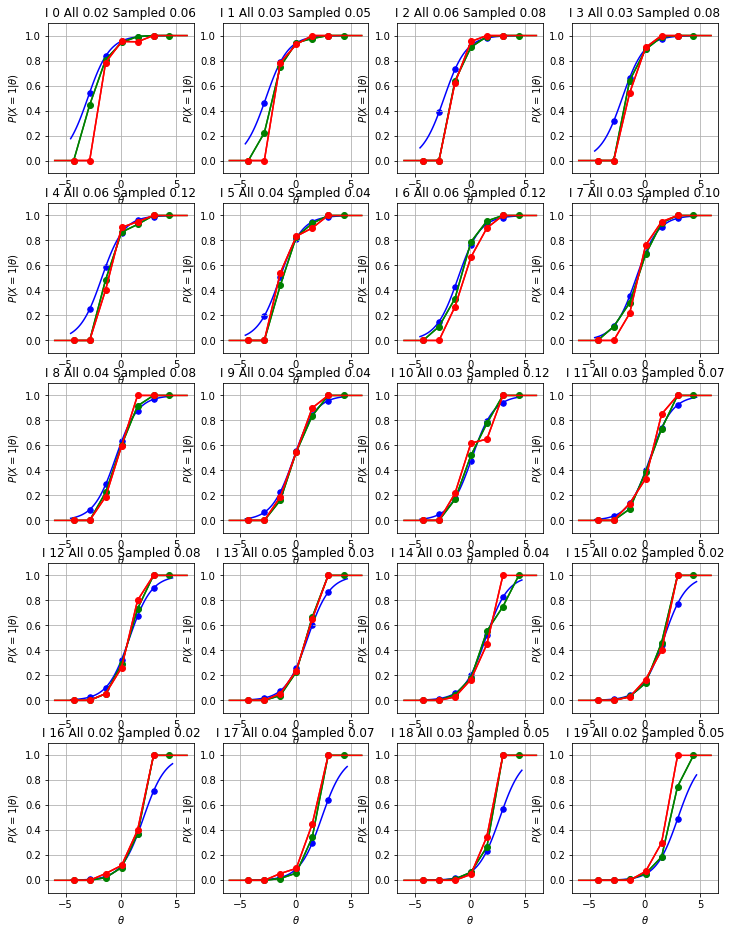

In [67]:
fig, axs = plt.subplots(I // 4, 4, figsize=(12, 0.8*I))
for i in range(I):
    ax = axs[i // 4, i % 4]
# i = 0 # Item number
# ax = plt.gca()

    def model_irf(t): return nirt.simulate.simulate_data.three_pl_model(t, discrimination, b[i], asym)

    nirt.simulate.plot_irf.plot_model_irf(ax, grid[c[i]], model_irf, num_bins, color="blue", label="Original")
    irf[i].plot(ax, color="green", label="{} samples".format(theta.shape[0]))
    sampled_irf[i].plot(ax, color="red", label="{} samples".format(sample_size))

    def error_norm(irf):
        # Returns the scaled, weighted L2 norm of the error in the approximate IRF at the nodes.
        # Weight = bin count (so that all persons contribute the same weight to the norm: more
        # dense bins should count more).
        exact_irf = np.array([model_irf(t) for t in irf.node])
        error = exact_irf - irf.probability
        weight = irf.count
        return (sum(weight * error**2)/sum(weight))**0.5

    e_all = error_norm(irf[i])
    e_sampled = error_norm(sampled_irf[i])
    #print("All MSE {:.2f}".format(np.linalg.norm(e)/n**0.5))
    #print("Sampled MSE {:.2f}".format(np.linalg.norm(e)/n**0.5))
    ax.set_title("I {} All {:.2f} Sampled {:.2f}".format(i, e_all, e_sampled))
    ax.grid(True)
#    _ = ax.legend()

    #d = (sampled_irf[i].count > 0) & (irf[i].probability > 0)
    #print("|all samples - sampled|  MSE {:.2f}".format(np.linalg.norm(sampled_irf.probability[d] - irf[i].probability[d])/n**0.5))

In [68]:
print(grid[0])
print(list(map(len, grid[0].bin)))
print(list(map(len, sampled_grid[0].bin)))
i = 15
print(irf[i])
print(sampled_irf[i])

Grid[num_bins=5, center=[-2.82878972 -1.38150893  0.06577185  1.51305263  2.96033341], endpoint=[-3.55243011 -2.10514932 -0.65786854  0.78941224  2.23669302  3.68397381]]
[9, 286, 450, 251, 4]
[1, 37, 42, 20, 0]
count [  9 286 450 251   4] score [  0   9  62 116   4] P [0.         0.03146853 0.13777778 0.46215139 1.        ]
count [ 1 37 42 20] score [0 1 7 8] P [0.         0.02702703 0.16666667 0.4       ]


$P_i(\theta)$ is generally monotonically increasing. The discrete approximation to the original synthetic (parametric) form is excellent. 20 persons per bin gives a reasonable approximation.

In [69]:
sampled_irf[i]

count [ 1 37 42 20] score [0 1 7 8] P [0.         0.02702703 0.16666667 0.4       ]

# Initial Guess for incoming $\theta$ (upon refinement)
When we add more persons to the simulation at each refinement step, we use the MLE ($T=0$) as the initial guess for the added persons's $\theta_p$'s.

In [70]:
            # Activate a sample of persons so that the (average) person bin size remains constant during continuation.
            # Note that the temperature may continue decreasing even after all persons have been activated.
            if inactive.size:
                sample_size = 5 * num_bins
                sample = np.random.choice(inactive, size=min(inactive.size, sample_size), replace=False)


theta[sample] = [[likelihood.parameter_mle(p, c, max_iter=5) for c in range(self.C)] for p in sample]

NameError: name 'self' is not defined

In [ ]:
# Check whether the likelihood of a person's theta is concave (has a unique maximum). Verify
# that the MLE is close to the argmax.
dim = 0
for p in range(3):
    likelihood.plot_person_log_likelihood(p, dim)
    # See that we can find this minimum with a root finder.
    t = likelihood.parameter_mle(p, dim)
    print("p {} MLE estimator: {}".format(p, t))
    plt.plot(t, likelihood.log_likelihood_term(t, (np.array([p]), np.array([dim]))), 'ro', markersize=8)
    plt.show()
    grid = np.linspace(-nirt.irf.M, nirt.irf.M, n + 1)
    active = np.tile([p, dim], (grid.size, 1))
    likelihood_values = likelihood.log_likelihood_term(grid, active=(active[:, 0], active[:, 1]))
    print(grid)
    print(likelihood_values)


# Improving $\theta$ estimates with MCMC

In [ ]:
theta = solver.initial_guess()
n = 10
T = 1
t = solver.solve_at_resolution(n, T, theta)